# Crop Biomass through Planet subscriptions API
Accessing comprehensive and accurate environmental data is essential for optimizing agricultural practices and making informed decisions. The Crop Biomass Planetary Variables dataset offers a wealth of information related to biomass dynamics, providing valuable insights into vegetation growth and crop health. In this Jupyter Notebook, you will retrieve and analyze Crop Biomass data using the Subscriptions API, through the process of data retrieval, filtering, manipulation, and visualization. By harnessing the capabilities of the Subscriptions API, you can effectively leverage the Crop Biomass Planetary Variables dataset to gain valuable insights and enhance your understanding of ecological dynamics within your agricultural context. In addition, we will also show how to deliver a subscription to a cloud storage location and a Sentinel Hub collection, to leverage all functionalities of the Planet Insights Platform.

For more information on working with Planetary Variables in the Subscriptions API, see:
- 📚 [Subscribing to Planetary Variables](https://developers.planet.com/docs/subscriptions/pvs-subs/)
- 📚 [Crop Biomass specifications](https://developers.planet.com/docs/planetary-variables/crop-biomass/)

## Before you start
To be able to run this code, you will need:
1. 🔑 A Planet API key. See: [Find Your API Key](https://developers.planet.com/quickstart/apis/#find-your-api-key)
2. 📦 A (virtual) environment with a recent (>= 3.8) Python installation and the following packages:
   - [Planet SDK for Python](https://planet-sdk-for-python-v2.readthedocs.io/en/latest/get-started/quick-start-guide/#step-1-install-python-37-and-a-virtual-environment)
   - [matplotlib](https://matplotlib.org/)
   - [rioxarray](https://corteva.github.io/rioxarray/html/installation.html)
3. 🌍 Access to the `BIOMASS-PROXY_V4.0_10` product.
4. (optional) Configured credentials for a cloud storage provider (Google Cloud Platform, Amazon Web Services, Microsoft Azure, or Oracle Collaboration Suite).

Below you will find a workflow to subscribe and retrieve Crop Biomass data. You will also find an example on how to plot the full timeseries and the annual growth season.
In another section, we will show how to deliver raster/GeoTIFF data to the Google Cloud Platform (GCP) and how this data can be visualized. You can adjust the code to use your chosen cloud storage provider as required. At the end, there is also an example demonstrating how to deliver data to a collection on Sentinel-Hub.

ℹ️ The notebook is written for Python 3.8 or greater and is based on the Planet Software Development Kit ([Planet SDK documentation](https://planet-sdk-for-python-v2.readthedocs.io)).

## Getting the data
First we import the required libraries:

In [1]:
import base64
import datetime as dt
from getpass import getpass
from io import StringIO
import json

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

from planet import Auth, Session
from planet.clients.subscriptions import SubscriptionsClient
from planet.subscription_request import planetary_variable_source, build_request


### Credentials
The next step is to [Authenticate with Planet services](https://planet-sdk-for-python-v2.readthedocs.io/en/latest/python/sdk-guide/#authenticate-with-planet-services). When running the following code you will be prompted to enter your [Planet API Key](https://developers.planet.com/quickstart/apis/#find-your-api-key), which will be stored securely for making the subsequent calls to the Subscriptions API.

In [2]:
api_key = getpass('Enter your API key:')
auth = Auth.from_key(api_key)

### Define your Area of Interest (AOI)
ℹ️ In your [Planet account dashboard](https://www.planet.com/account/#/dashboard), you can check your provisioned data - for this walkthrough, you will need to have access to the Crop Biomass data product. 

ℹ️ Make sure that your geometries are within your allocated quota, which represents the amount of data you can request for your areas of interest (AOIs). Before requesting data, you need to reserve quota for your AOIs using the [Quota API](https://developers.planet.com/docs/apis/quota/) or [Features Manager](https://developers.planet.com/docs/apps/features-manager/). This ensures that the data you request fits within your quota limits. You can monitor your remaining quota and current usage directly from the [dashboard]((https://www.planet.com/account/#/dashboard)) or the [Quota API](https://developers.planet.com/docs/apis/quota/). 

💡 **Tip:** There are several options to define your AOI. In this example we manually added the JSON for a field in Ohio, but you can also draw and copy a geometry using online tools such as the [SentinelHub EO-browser](https://apps.sentinel-hub.com/eo-browser/) or [GeoJSON.io](https://geojson.io/#map=2/0/20). Similarly, you can use Planet's [features manager](https://developers.planet.com/docs/apps/features-manager/) to create a feature and add provide it's URI (Uniform Resource Identifier) as the AOI variable in the code below (some examples of public features are provided [here](https://www.planet.com/features/?org=1&loc=0,0,2.86z)).

In [3]:
# Area of Interest (AOI) - Field in Ohio
AOI = {
    "type":"Polygon",
    "coordinates":[[
        [-83.568964,40.154015],
        [-83.566904,40.156212],
        [-83.564501,40.157557],
        [-83.563728,40.156901],
        [-83.562698,40.157131],
        [-83.561068,40.157098],
        [-83.559737,40.157229],
        [-83.55742,40.15864],
        [-83.553686,40.159296],
        [-83.551626,40.158869],
        [-83.549995,40.159492],
        [-83.548365,40.159197],
        [-83.546948,40.159755],
        [-83.54403,40.156672],
        [-83.547077,40.155688],
        [-83.546004,40.154507],
        [-83.547721,40.154113],
        [-83.549094,40.15372],
        [-83.549953,40.153031],
        [-83.551283,40.150866],
        [-83.5533,40.150538],
        [-83.554716,40.150341],
        [-83.555532,40.150046],
        [-83.556647,40.149193],
        [-83.559222,40.146798],
        [-83.56214,40.149357],
        [-83.564544,40.149423],
        [-83.56523,40.149849],
        [-83.568964,40.154015]
    ]]
}


Optionally, you can also load your geometry from a .geojson file 

In [ ]:
# Get the geometry from a geojson file
fname="my_geometry.geojson"
with open(fname, "r") as file:
    geojson_data = json.load(file)
AOI = geojson_data["features"][0]

### Define your subscription
In this example, we demonstrate how to create a subscription to access approximately 3 years of Crop Biomass data for a specific field in Ohio.

ℹ️ Subscriptions can be configured with or without a delivery parameter. The delivery parameter specifies a storage location for delivering raster data. However, for this initial analysis, we are only interested in the metadata and do not require the actual raster assets. Therefore, we have omitted the delivery parameter to create a metadata-only (producing time series without rasters) subscription.

In [4]:
subscription_name = "crop_biomass_ohio_subscription_example"

pv_source = planetary_variable_source(var_type="biomass_proxy",
                                      var_id="BIOMASS-PROXY_V4.0_10",
                                      geometry=AOI,
                                      start_time=dt.datetime(2020, 1, 15),
                                      end_time=dt.datetime(2023, 4, 24))

request = build_request(subscription_name, source=pv_source, delivery={},)

### Create the subscription
Using the [create_subscription](https://planet-sdk-for-python-v2.readthedocs.io/en/latest/python/sdk-reference/#planet.clients.subscriptions.SubscriptionsClient.create_subscription) method, we POST the request defined above to `https://api.planet.com/subscriptions/v1`

In [5]:
# Create the subscription using the function create_subscription
async with Session(auth=auth) as sess:
    cl = SubscriptionsClient(sess)
    subscription_desc = await cl.create_subscription(request)
print(f"{subscription_desc['id']} named {subscription_desc['name']} created")

794c4df1-df53-4bd1-8c4a-d2b4fc9ba6a0 named crop_biomass_ohio_subscription_example created


### Monitor the subscription
We now monitor the progress of the subscription with the [get_subscription](https://planet-sdk-for-python-v2.readthedocs.io/en/latest/python/sdk-reference/#planet.clients.subscriptions.SubscriptionsClient.get_subscription) method (subscription status is explained by [https://developers.planet.com/docs/subscriptions/](https://developers.planet.com/docs/subscriptions/#subscription-status))

In [6]:
# get the subscription using the function create_subscription
async with Session(auth=auth) as sess:
    cl = SubscriptionsClient(sess)
    subscription_desc = await cl.get_subscription(subscription_id=subscription_desc['id'])
print(f"{subscription_desc['id']} named {subscription_desc['name']} is {subscription_desc['status']}")

794c4df1-df53-4bd1-8c4a-d2b4fc9ba6a0 named crop_biomass_ohio_subscription_example is completed


### Retrieve the data
We can start retrieving the subscription data even if the status is 'running'. The `metadata-only` (timeseries) results generated for this subscription is retrieved directly in CSV format with `get_results_csv`. We can use the Pandas library to read this into a DataFrame to perform further analysis and to create a nice time series visualization.

💡 Read more about the different state of [Subscription Status](https://developers.planet.com/docs/subscriptions/#subscription-status) or the valid_percent in [Metadata Results (Time Series)](https://static.prod.planet-labs.com/devcenter/dev/rel-pv-eap/docs/subscriptions/pvs-subs/#metadata-results-time-series).

In [7]:
async with Session(auth=auth) as sess:
    cl = SubscriptionsClient(sess)
    results_desc = cl.get_results_csv(subscription_id=subscription_desc['id'])
    results_desc_list = [i async for i in results_desc]

df = pd.read_csv(StringIO("\n".join(results_desc_list)), parse_dates=["item_datetime", "local_solar_time"], index_col="local_solar_time",)
df.head()

,id,item_datetime,status,created,updated,errors,CB.band-1.mean,CB.band-1.valid_percent,item_id,source_id
local_solar_time,,,,,,,,,,
2020-01-15,2c13a752-10d2-421d-bfe4-89e7fad7033c,2020-01-15 06:00:00+00:00,SUCCESS,2024-10-22T07:43:41.699596Z,2024-10-22T07:43:41.699597Z,{},0.652,100,BIOMASS-PROXY_V4.0_10_2020-01-15T0000,BIOMASS-PROXY_V4.0_10
2020-01-16,9067c43a-ceaa-4092-8d43-8ab2e80ecbba,2020-01-16 06:00:00+00:00,SUCCESS,2024-10-22T07:43:40.76447Z,2024-10-22T07:43:40.764471Z,{},0.651,100,BIOMASS-PROXY_V4.0_10_2020-01-16T0000,BIOMASS-PROXY_V4.0_10
2020-01-17,9d3f5f6b-8bec-4cc3-a369-cf84487d4228,2020-01-17 06:00:00+00:00,SUCCESS,2024-10-22T07:43:41.682024Z,2024-10-22T07:43:41.682024Z,{},0.650,100,BIOMASS-PROXY_V4.0_10_2020-01-17T0000,BIOMASS-PROXY_V4.0_10
2020-01-18,f0f88982-3100-4608-a09c-9268ac3f1ea6,2020-01-18 06:00:00+00:00,SUCCESS,2024-10-22T07:43:41.712315Z,2024-10-22T07:43:41.712315Z,{},0.649,100,BIOMASS-PROXY_V4.0_10_2020-01-18T0000,BIOMASS-PROXY_V4.0_10
2020-01-19,5f1f9b98-257d-4cc0-be1c-ed053b29747d,2020-01-19 06:00:00+00:00,SUCCESS,2024-10-22T07:43:41.739413Z,2024-10-22T07:43:41.739413Z,{},0.649,100,BIOMASS-PROXY_V4.0_10_2020-01-19T0000,BIOMASS-PROXY_V4.0_10


## Visualize Timeseries
Now that we have the timeseries data in a Pandas DataFrame, we can visualize it. But first we will filter out invalid results, by removing null values and crop biomass values below 0. Since the subscription might still be running, we also remove the `QUEUED` items.

In [8]:
# Filter by valid data only
df = df[df["CB.band-1.valid_percent"].notnull()]
df = df[df["CB.band-1.valid_percent"] > 0]
df = df[df["status"] != 'QUEUED']

Next, we calculate the daily crop biomass and visualize the values over time using a line plot. 

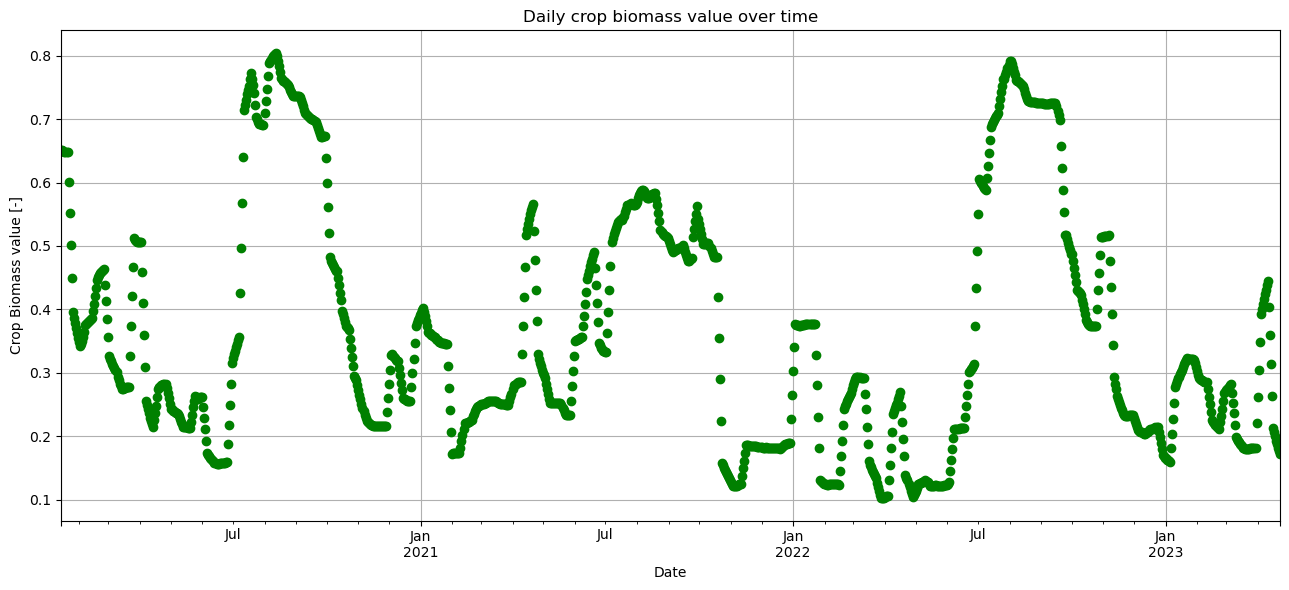

In [9]:
# Plot the results
fig, ax = plt.subplots(figsize=(13, 6))
df['CB.band-1.mean'].plot(ax=ax, kind='line', style='o', color="green")
ax.set_title("Daily crop biomass value over time")
ax.set_xlabel('Date')
ax.set_ylabel('Crop Biomass value [-]')
ax.grid(True)
fig.tight_layout()
plt.show()

In the example below, the code filters the dataframe to include only the months from May to November, focusing on the growing season for the years 2020, 2021, and 2022. It then plots these three growing seasons as separate lines and uses a pseudo year (2000, a leap year) for the x-axis to ensure the dates range from May 1st to October 31st. Additionally, it plots a dotted line representing the median of `CB.band-1.mean` across all years.

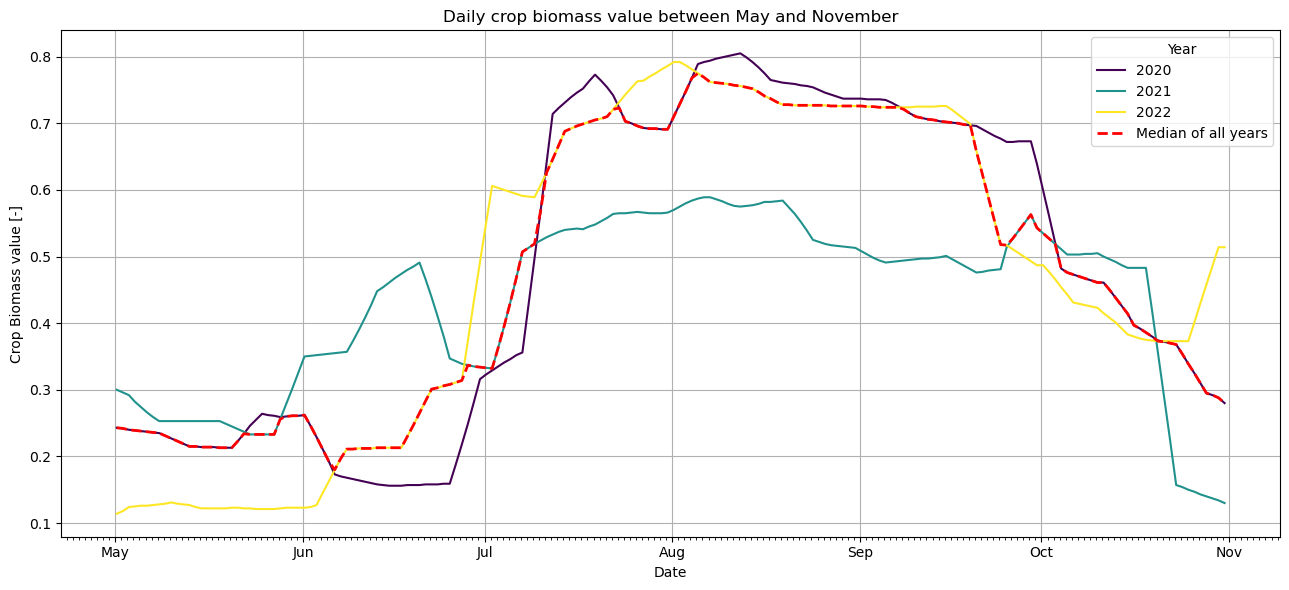

In [10]:
# Filter rows where the month of 'item_datetime' is between May and November
df_growing_season = df[(df['item_datetime'].dt.month >= 5) & (df['item_datetime'].dt.month < 11)].copy()

# Add a pseudo year to account for leap years
df_growing_season['plot_date'] = df_growing_season.item_datetime.apply(lambda dt: dt.replace(year=2000))

# Set plot_date as index for easy plotting
df_growing_season.set_index('plot_date', inplace=True)

# Get the unique years for coloring
years = sorted(df_growing_season['item_datetime'].dt.year.unique())

# Create a color map, based on the number of years
colors = plt.cm.viridis(np.linspace(0, 1, len(years)))

# Initialize a figure for the plot
fig, ax = plt.subplots(figsize=(13, 6))

# Plot each year's data
for idx, (year, df_year) in enumerate(df_growing_season.groupby(df_growing_season['item_datetime'].dt.year)):
    ax.plot(df_year['CB.band-1.mean'], color=colors[idx], label=year)

# Compute and plot the median of all years
df_all_years_median = df_growing_season.groupby(df_growing_season.index)['CB.band-1.mean'].median()
ax.plot(df_all_years_median.index, df_all_years_median, color='red', linestyle="--", label='Median of all years', linewidth=2)

# Format the x-axis to display months
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

ax.set_title('Daily crop biomass value between May and November')
ax.set_xlabel('Date')
ax.set_ylabel('Crop Biomass value [-]')
ax.legend(title='Year')
ax.grid(True)
fig.tight_layout()
plt.show()

## Visualize Rasters
In addition to providing metadata over an area of interest, you can also configure the delivery of raster results directly to a cloud storage location. We will use the same method as above to generate the request but now provide an additional `delivery` configuration. In this example, we will focus on June and July 2022.

See the [supported delivery options](https://developers.planet.com/docs/subscriptions/delivery/#supported-delivery-options) or the [API reference](https://developers.planet.com/docs/subscriptions/reference/#tag/subscriptions/operation/createSubscription) to review the configuration options for different cloud storage providers. This example uses Google Cloud Storage.

To deliver results directly to a Google Cloud Storage bucket, specify the delivery location and provide your authentication credentials. These credentials will require read/write permissions on the specified bucket. See the [Google Cloud documentation](https://cloud.google.com/iam/docs/keys-create-delete#iam-service-account-keys-create-console) on how to create a service account key with the appropriate permissions. When using AWS, Azure or OCS, use the corresponding credentials for those platforms.

In [11]:
import rioxarray as rx
import rasterio

In [12]:
# Only for Cloud Storage Delivery
bucket_name="<YOUR BUCKET NAME>"
GOOGLE_APPLICATION_CREDENTIALS="~/.config/gcloud/application_default_credentials.json" # Adjust to your json file location for a GCP service account key with Cloud Storage permissions

# Credentials are expected in base64 format -the following reads the json key as bytes,
# applies the base64 encoding and decodes back to a python str
with open(GOOGLE_APPLICATION_CREDENTIALS, "rb") as f:
    gcs_credentials_base64 = base64.b64encode(f.read()).decode()

# Your GCP bucket and credentials to save rasters
delivery_config_gcp = {
    "type": "google_cloud_storage",
    "parameters": {
        "bucket": bucket_name,
        "credentials": gcs_credentials_base64,
    }
}

In [13]:
subscription_name = "crop_biomass_ohio_subscription_example_2022"

pv_source = planetary_variable_source(var_type="biomass_proxy",
                                      var_id="BIOMASS-PROXY_V4.0_10",
                                      geometry=AOI,
                                      start_time=dt.datetime(2022, 6, 10),
                                      end_time=dt.datetime(2022, 7, 31))

request = build_request(subscription_name, source=pv_source, delivery=delivery_config_gcp,)

In [14]:
# Create the subscription using the function create_subscription
async with Session(auth=auth) as sess:
    cl = SubscriptionsClient(sess)
    subscription_details = await cl.create_subscription(request)
print(f"{subscription_details['id']} named {subscription_details['name']} created")

e9a56744-afd1-4df6-861f-d6710bda10ac named crop_biomass_ohio_subscription_example_2022 created


The geotiff (raster) files will now be delivered to our Cloud Storage bucket.

The rioxarray extension to [rasterio](https://rasterio.readthedocs.io/en/latest/installation.html) can be used to open and map the delivered GeoTIFF files directly from their cloud storage location.

Rasterio uses GDAL under the hood, which supports accessing [network based file systems](https://gdal.org/user/virtual_file_systems.html#network-based-file-systems) across different cloud providers. For more information, see:

- [Amazon Web Service](https://gdal.org/user/virtual_file_systems.html#vsis3-aws-s3-files)
- [Google Cloud](https://gdal.org/user/virtual_file_systems.html#vsigs-google-cloud-storage-files)
- [Microsoft Azure](https://gdal.org/user/virtual_file_systems.html#vsiaz-streaming-microsoft-azure-blob-files-streaming)

In the following example, the data is read directly from our previously configured Google Cloud Storage bucket to visualize the crop biomass at July 1, 15 and 31, 2021.

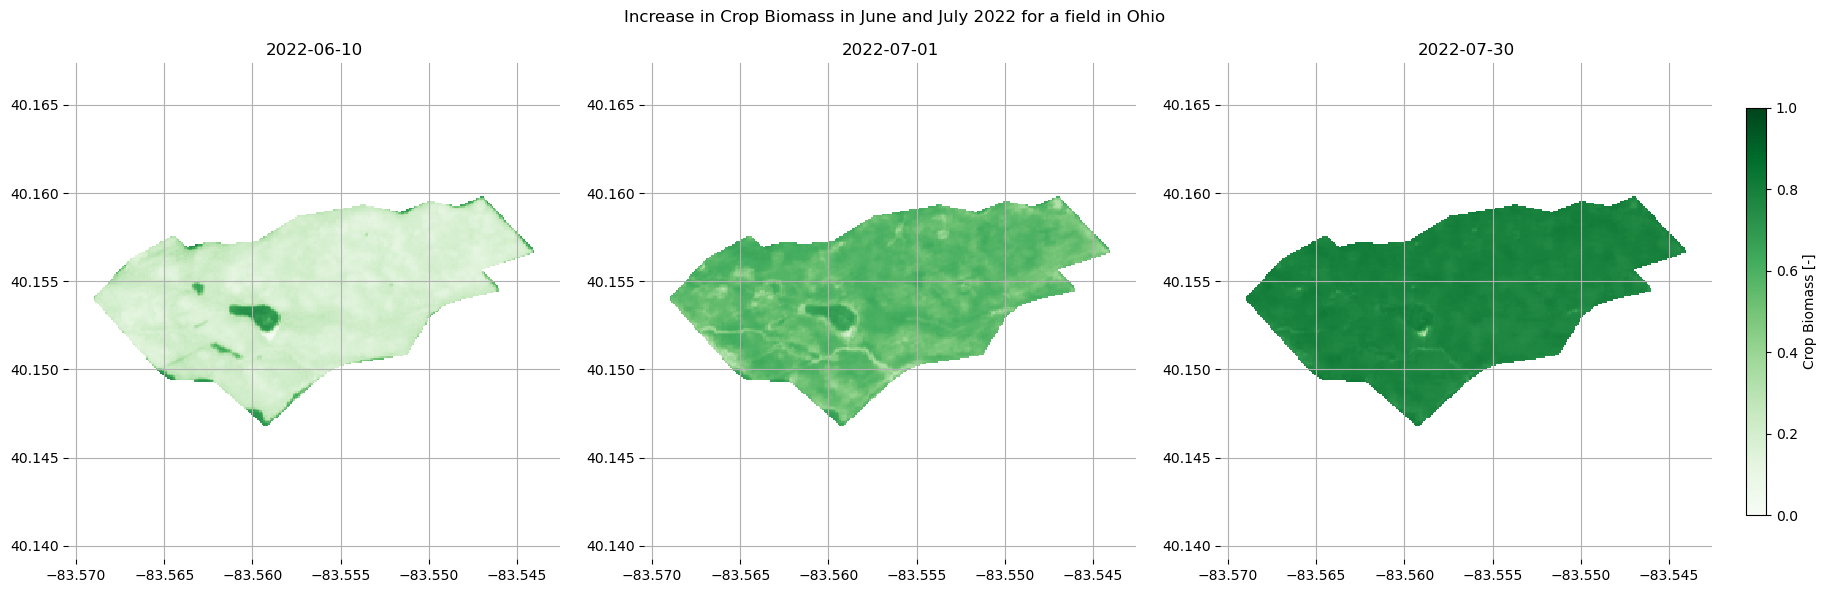

In [15]:
# Construct the bucket paths for the rasters to be plotted
dates_to_plot = ["2022-06-10", "2022-07-01", "2022-07-30"]
subscription_id = subscription_details["id"]
files = [f"gs://{bucket_name}/{subscription_id}/{date.replace('-','/')}/BIOMASS-PROXY_V4.0_10-{date.replace('-','')}T0000_CB.tiff" for date in dates_to_plot]

# Iniitiate a figure to plot the rasters
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
fig.suptitle("Increase in Crop Biomass in June and July 2022 for a field in Ohio")

for i, date in enumerate(dates_to_plot):

    # Use the Google Application credentials to allow access to the storage location
    with rasterio.env.Env(GOOGLE_APPLICATION_CREDENTIALS=GOOGLE_APPLICATION_CREDENTIALS):
        cb_data = rx.open_rasterio(files[i], mask_and_scale=True, band_as_variable=True)

        cb_data = cb_data.rename_vars({
            "band_1":"Crop Biomass [-]",
        })

        img = cb_data["Crop Biomass [-]"].plot(ax=ax[i], cmap="Greens", vmin=0, vmax=1, add_colorbar=False)

    ax[i].set_title(f"{date}")
    ax[i].grid(True)
    ax[i].axis("equal")
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")
    ax[i].set_frame_on(False)

fig.tight_layout()
cbar = fig.colorbar(img, ax=ax, orientation='vertical', fraction=0.012, pad=0.02)
cbar.set_label('Crop Biomass [-]')


## Delivery to Sentinel Hub Collection
One can also deliver outputs from the subscription's API as a Sentinel Hub collection, to be able to use the results with the full suite of imagery and statistical tools on the Planet Insights Platform. Instead of specifying a cloud storage delivery you can specify "Sentinel Hub" as the destination for the delivery (check the cell below). 

To visualize your subscription in the Sentinel Hub [EO Browser](https://apps.sentinel-hub.com/eo-browser/), sign in to your [dashboard](https://apps.sentinel-hub.com/dashboard/#/account/settings) and find the subscription under "My Collections." Copy the collection ID into a configuration under the "Configuration Utility" tab. You can then open that configuration in EO Browser to explore and visualize your data!

Further reading:
- 📚 [Planet Pulse: Imagery Delivery in the Subscriptions API](https://www.planet.com/pulse/imagery-delivery-in-the-subscriptions-api/)
- 📚 [Delivery to Sentinel Hub Collection](https://developers.planet.com/docs/subscriptions/delivery/#delivery-to-sentinel-hub-collection)
- 📚 [Planet SDK API reference](https://planet-sdk-for-python-v2.readthedocs.io/en/latest/python/sdk-reference/#planet.subscription_request.sentinel_hub)
- 📚 [Sentinel Hub Dashboard](https://www.sentinel-hub.com/develop/dashboard/)
- 📚 [EO Browser User Guide](https://www.sentinel-hub.com/explore/eobrowser/user-guide/)



In [35]:
from planet.subscription_request import sentinel_hub

subscription_name = "crop_biomass_ohio_subscription_example_2022_sentinel_hub"

pv_source = planetary_variable_source(var_type="biomass_proxy",
                                      var_id="BIOMASS-PROXY_V4.0_10",
                                      geometry=AOI,
                                      start_time=dt.datetime(2022, 6, 10),
                                      end_time=dt.datetime(2022, 7, 31))

request = build_request(
    subscription_name, 
    source=pv_source, 
    hosting=sentinel_hub(collection_id=None),
    # Use for existing collection:
    # hosting=sentinel_hub(collection_id="<your_collection_id>"), 
)

async with Session(auth=auth) as sess:
    cl = SubscriptionsClient(sess)
    subscription = await cl.create_subscription(request)
print(f"{subscription['id']} named {subscription['name']} created")
print(f"sentinel_hub collection_id: {subscription['hosting']['parameters']['collection_id']}")


1b361619-c982-4251-bda2-9d7f82c23dc6 named crop_biomass_ohio_subscription_example_2022_sentinel_hub created
sentinel_hub collection_id: ac66a3f8-eb34-439c-9637-c632498d2b12
